# Brief description of the problem and data (5 pts)

<center><img src='https://i.icanvas.com/list-hero/claude-monet.jpg' height=350></center>
<p>
<h1><center> Kaggle Competition - I’m Something of a Painter Myself </center></h1>
<h2><center> Generating Monet paintings using CycleGAN</center></h2>

#### This goal of this notebook is to implement a CycleGAN archtecture model to generate Monet painting.  A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator. The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

#### My task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

#### CycleGAN references:
- [Git repository](https://junyanz.github.io/CycleGAN/) with many cool informations.
- [ArXiv paper](https://arxiv.org/pdf/1703.10593.pdf)
- [Understanding and Implementing CycleGAN in TensorFlow](https://hardikbansal.github.io/CycleGANBlog/)


### What is CycleGAN?

CycleGAN (Cycle-Consistent Generative Adversarial Networks) is a type of Generative Adversarial Network (GAN) designed for image-to-image translation tasks where paired examples are not available. For example, our task is to turn photos into Monet paintings

#### Turning photos into Monet paintings
![](https://junyanz.github.io/CycleGAN/images/painting2photo.jpg)


## Dataset Description

The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos.  

The total size of the dataset is 385.87MB:
- monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
- monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format ( 5 files)
- photo_jpg - 7028 photos sized 256x256 in JPEG format
- photo_tfrec - 7028 photos sized 256x256 in TFRecord format (20 files)



## Environment Setup

In [1]:
import os, random, json, PIL, shutil, re
import numpy as np
import pandas as pd
from kaggle_datasets import KaggleDatasets
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
from tensorflow.keras import Model, losses, optimizers
import seaborn as sns
import matplotlib.pyplot as plt


# TPU Configuration
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)
#REPLICAS = strategy.num_replicas_in_sync
#print(f'REPLICAS: {REPLICAS}')
AUTO = tf.data.experimental.AUTOTUNE

Number of replicas: 1


# Load data

The dataset is sourced from Kaggle's repository. The following code sets up the file path and loads the filenames into the notebook.

In [2]:
GCS_PATH = KaggleDatasets().get_gcs_path('monet-gan-getting-started')

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

n_monet_samples = count_data_items(MONET_FILENAMES)
n_photo_samples = count_data_items(PHOTO_FILENAMES)

print(f'Monet TFRecord files: {len(MONET_FILENAMES)}')
print(f'Monet image files: {n_monet_samples}')
print(f'Photo TFRecord files: {len(PHOTO_FILENAMES)}')
print(f'Photo image files: {n_photo_samples}')

Monet TFRecord files: 5
Monet image files: 300
Photo TFRecord files: 20
Photo image files: 7038


## Helper functions

I am using a third-party library of functions to facilitate the machine learning process. The library details are as follows:

In [3]:
# helper functions provided by DimitreOliveira - https://www.kaggle.com/code/dimitreoliveira/introduction-to-cyclegan-monet-paintings#notebook-container 

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        'image_name': tf.io.FixedLenFeature([], tf.string),
        #'file_size': tf.io.FixedLenFeature([], tf.int64),  # added
        'image':      tf.io.FixedLenFeature([], tf.string),
        'target':     tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def get_gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):

    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)

    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
    if shuffle:
        monet_ds = monet_ds.shuffle(2048)
        photo_ds = photo_ds.shuffle(2048)
        
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    monet_ds = monet_ds.cache()
    photo_ds = photo_ds.cache()
    monet_ds = monet_ds.prefetch(AUTO)
    photo_ds = photo_ds.prefetch(AUTO)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds

def display_samples(ds, row, col):  #passing in a dataset
    ds_iter = iter(ds)
    plt.figure(figsize=(15, int(15*row/col)))
    for j in range(row*col):
        example_sample = next(ds_iter)
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
    plt.show()
        
def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)
        
        plt.subplot(121)
        plt.title("input image")
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title("Generated image")
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()
        
def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1
                

# Model functions
def downsample(filters, size, apply_instancenorm=True, strides=2):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(L.Conv2D(filters, size, strides=strides, padding='same',
                        kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(L.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False, strides=2):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(L.Conv2DTranspose(filters, size, strides=strides, padding='same',
                                 kernel_initializer=initializer, use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(L.Dropout(0.5))

    result.add(L.ReLU())

    return result

# Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)




# Setting parameters

In [8]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
EPOCHS = 20
BATCH_SIZE = 1

### The followings are some sample Monet paintings

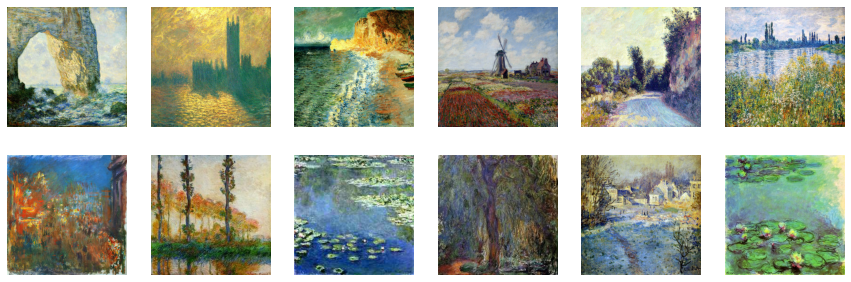

In [5]:
#display_samples(load_dataset(MONET_FILENAMES).batch(1), 4, 6)
display_samples(load_dataset(MONET_FILENAMES).batch(1), 2, 6)

### The followings are some sample photos

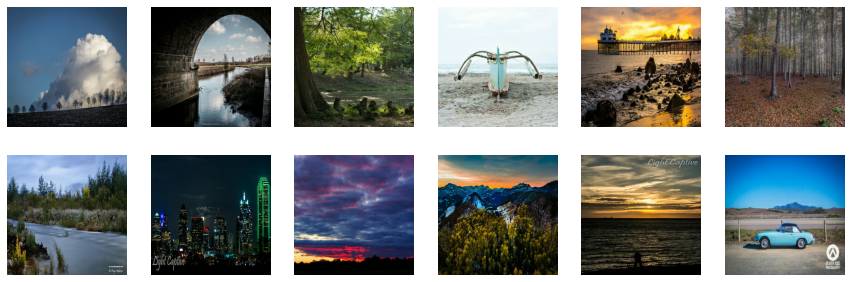

In [6]:
display_samples(load_dataset(PHOTO_FILENAMES).batch(1), 2, 6)

## Analyzing the pixel distribution of the Monet pictures

The following code attempts to find the distribution of a batch of Monet images. From the distribution, we observe two peaks for the pixel values, which are normalized to the range between -1 and 1. The distribution peaks at standardized values of 0 and 0.625, equivalent to pixel values of 127 and 207, respectively. The distribution skews more heavily towards the higher value side, indicating that the images tend to have lighter colors.

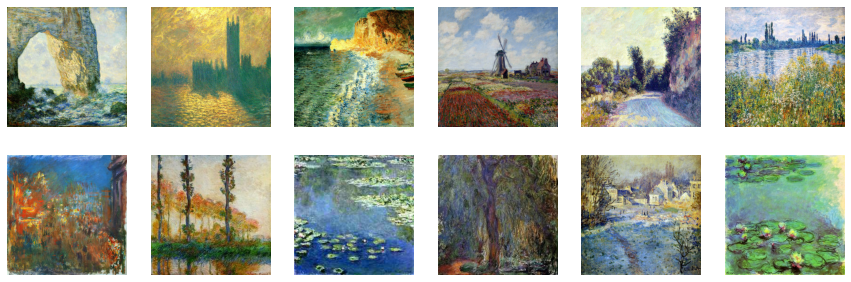

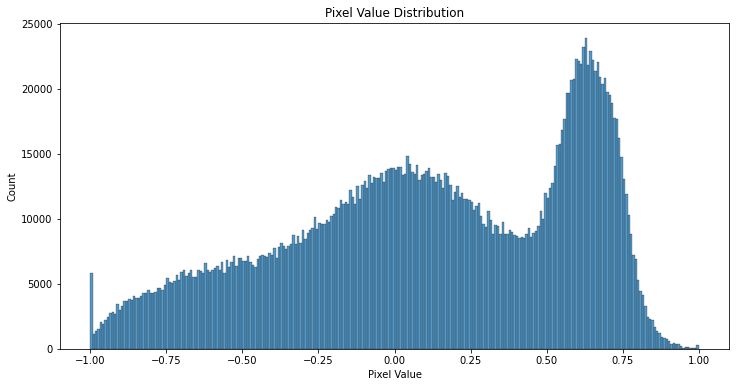

Mean Pixel Value: 0.11433131247758865
Median Pixel Value: 0.13725495338439941
Standard Deviation: 0.4733981192111969
Minimum Pixel Value: -1.0
Maximum Pixel Value: 1.0


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

row = 2
col = 6
ds_iter = iter(load_dataset(MONET_FILENAMES).batch(1))
plt.figure(figsize=(15, int(15*row/col)))
for j in range(row*col):
    example_sample = next(ds_iter)
    plt.subplot(row,col,j+1)
    plt.axis('off')
    plt.imshow(example_sample[0] * 0.5 + 0.5)
plt.show()

# Analyze pixel distribution
pixel_values = []
for j in range(row*col):
    ds_iter = iter(load_dataset(MONET_FILENAMES).batch(1))
    example_sample = next(ds_iter)
    pixel_values.extend(example_sample[0].numpy().flatten())


# Histogram of pixel values
plt.figure(figsize=(12, 6))
sns.histplot(pixel_values, bins=256)
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Count')
plt.show()

# Descriptive statistics
print(f'Mean Pixel Value: {np.mean(pixel_values)}')
print(f'Median Pixel Value: {np.median(pixel_values)}')
print(f'Standard Deviation: {np.std(pixel_values)}')
print(f'Minimum Pixel Value: {np.min(pixel_values)}')
print(f'Maximum Pixel Value: {np.max(pixel_values)}')

## Comparing pixel distribution between Monet and Real

The following plot shows the pixel distribution comparison between Monet images and real photos in the dataset. The pixel distribution for Monet images appears more evenly distributed, whereas the real photos exhibit more fluctuations. Notably, there is a sudden drop at the high-value end of the pixel range in the distribution for real photos.

In general, Monet images tend to have more pixel distribution centered around the middle of the pixel spectrum, whereas real photos show a slightly broader distribution extending towards the edges of the pixel spectrum.

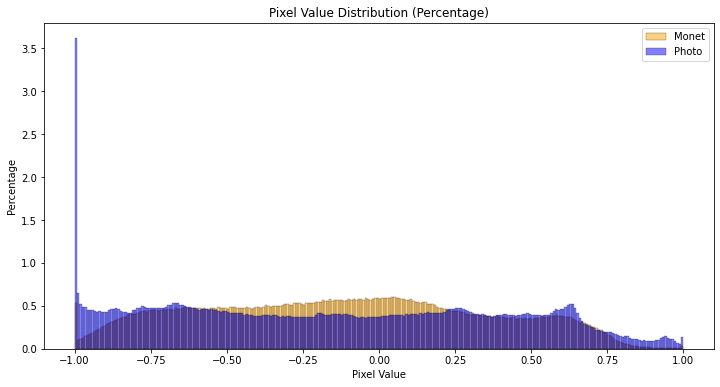

Photo Mean Pixel Value: -0.1484280526638031
Photo Median Pixel Value: -0.1607843041419983
Photo Standard Deviation: 0.551580011844635
Photo Minimum Pixel Value: -1.0
Photo Maximum Pixel Value: 1.0
Monet Mean Pixel Value: -0.12002459168434143
Monet Median Pixel Value: -0.12156862020492554
Monet Standard Deviation: 0.4635908603668213
Monet Minimum Pixel Value: -1.0
Monet Maximum Pixel Value: 1.0


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load and analyze Monet pixel distribution
monet_pixel_values = []
for filename in MONET_FILENAMES:
    ds = load_dataset([filename]).batch(1)
    ds_iter = iter(ds)
    example_sample = next(ds_iter)
    monet_pixel_values.extend(example_sample[0].numpy().flatten())

# Load and analyze Photo pixel distribution
photo_pixel_values = []
for filename in PHOTO_FILENAMES:
    ds = load_dataset([filename]).batch(1)
    ds_iter = iter(ds)
    example_sample = next(ds_iter)
    photo_pixel_values.extend(example_sample[0].numpy().flatten())

# Convert lists to numpy arrays for easier manipulation
monet_pixel_values = np.array(monet_pixel_values)
photo_pixel_values = np.array(photo_pixel_values)

# Normalize histogram to show percentages
plt.figure(figsize=(12, 6))
sns.histplot(monet_pixel_values, color='orange', label='Monet', bins=256, alpha=0.5, stat='percent')
sns.histplot(photo_pixel_values, color='blue', label='Photo', bins=256, alpha=0.5, stat='percent')
plt.title('Pixel Value Distribution (Percentage)')
plt.xlabel('Pixel Value')
plt.ylabel('Percentage')
plt.legend()
plt.show()

# Descriptive statistics
print(f'Photo Mean Pixel Value: {np.mean(photo_pixel_values)}')
print(f'Photo Median Pixel Value: {np.median(photo_pixel_values)}')
print(f'Photo Standard Deviation: {np.std(photo_pixel_values)}')
print(f'Photo Minimum Pixel Value: {np.min(photo_pixel_values)}')
print(f'Photo Maximum Pixel Value: {np.max(photo_pixel_values)}')

print(f'Monet Mean Pixel Value: {np.mean(monet_pixel_values)}')
print(f'Monet Median Pixel Value: {np.median(monet_pixel_values)}')
print(f'Monet Standard Deviation: {np.std(monet_pixel_values)}')
print(f'Monet Minimum Pixel Value: {np.min(monet_pixel_values)}')
print(f'Monet Maximum Pixel Value: {np.max(monet_pixel_values)}')


# Model Design and Architect

## Building version 1

I will implement a CycleGAN to transform images between Monet-style and photo-style. The initial version of the CycleGAN will be simplified, featuring fewer downsampling and upsampling layers.

## Generator model

The initial CycleGAN generator model will be compact, featuring 3 downsampling and 3 upsampling layers. Downsampling layers reduce dimensions while increasing depth to extract crucial features from the data. These layers include a combination of convolutional, pooling, batch normalization, and activation layers.

Conversely, upsampling layers reverse the effects of downsampling to restore the dimensions of the input data. By employing skip connections between downsampling and upsampling layers, the GAN can effectively learn to generate detailed, high-quality images. This approach helps in capturing and reconstructing complex patterns within the data.

In [5]:
OUTPUT_CHANNELS = 3

def generator_fn():
    inputs = L.Input(shape=[HEIGHT, WIDTH, CHANNELS])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4),                          # (bs, 64, 64, 128)
        downsample(256, 4),                          # (bs, 32, 32, 256)        
    ]

    up_stack = [
        upsample(256, 4),                     # (bs, 32, 32, 512)
        upsample(128, 4),                     # (bs, 64, 64, 256)
        upsample(64, 4),                      # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = L.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                             strides=2,
                             padding='same',
                             kernel_initializer=initializer,
                             activation='tanh') # (bs, 256, 256, 3)
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = L.Concatenate()([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)

## Discriminator model

The first attempt for distriminator model will have 3 downsample layers and followed by a conv2D layer. 

In [6]:
def discriminator_fn():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    inp = L.Input(shape=[HEIGHT, WIDTH, CHANNELS], name='input_image')
    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
    # Final convolutional layer without normalization or activation
    last = L.Conv2D(1, 4, strides=1, padding='valid',
                 kernel_initializer=initializer)(down3)  # (bs, 29, 29, 1)
    return Model(inputs=inp, outputs=last)

## Build model (CycleGAN)

This implementation follows the standard CycleGAN architecture. In addition to computing the traditional generator and discriminator losses, it incorporates total cycle consistency loss and identity loss. The total cycle consistency loss ensures that generated images can accurately revert to their original form, while identity loss helps maintain the style of images across domains.

In [9]:
with strategy.scope():
    monet_generator = generator_fn() # transforms photos to Monet-esque paintings
    photo_generator = generator_fn() # transforms Monet paintings to be more like photos
    monet_discriminator = discriminator_fn() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = discriminator_fn() # differentiates real photos and generated photos

class CycleGan(Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            'monet_gen_loss': total_monet_gen_loss,
            'photo_gen_loss': total_photo_gen_loss,
            'monet_disc_loss': monet_disc_loss,
            'photo_disc_loss': photo_disc_loss
        }

## Loss functions

Below are the implementations of the four loss functions: discriminator loss, generator loss, total cycle consistency loss, and identity loss.

In [10]:
with strategy.scope():
    # Discriminator loss
    def discriminator_loss(real, generated):
        real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
    # Generator loss
    def generator_loss(generated):
        return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    
    # Cycle consistency loss
    with strategy.scope():
        def calc_cycle_loss(real_image, cycled_image, LAMBDA):
            loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

            return LAMBDA * loss1

    # Identity loss
    with strategy.scope():
        def identity_loss(real_image, same_image, LAMBDA):
            loss = tf.reduce_mean(tf.abs(real_image - same_image))
            return LAMBDA * 0.5 * loss

## Training model

The following code sets up the training process for building the model.


In [12]:
with strategy.scope():
    # Create generators
    monet_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

    # Create discriminators
    monet_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    
    # Create GAN
    gan_model = CycleGan(monet_generator, photo_generator, 
                         monet_discriminator, photo_discriminator)

    gan_model.compile(m_gen_optimizer=monet_generator_optimizer,
                      p_gen_optimizer=photo_generator_optimizer,
                      m_disc_optimizer=monet_discriminator_optimizer,
                      p_disc_optimizer=photo_discriminator_optimizer,
                      gen_loss_fn=generator_loss,
                      disc_loss_fn=discriminator_loss,
                      cycle_loss_fn=calc_cycle_loss,
                      identity_loss_fn=identity_loss)
    
history1 = gan_model.fit(get_gan_dataset(MONET_FILENAMES, PHOTO_FILENAMES, batch_size=BATCH_SIZE), 
                        steps_per_epoch=(n_monet_samples//BATCH_SIZE),
                        epochs=EPOCHS,
                        verbose=2).history

Epoch 1/20
300/300 - 65s - monet_gen_loss: 3.4580 - photo_gen_loss: 2.9115 - monet_disc_loss: 0.4412 - photo_disc_loss: 0.6223
Epoch 2/20
300/300 - 23s - monet_gen_loss: 3.7947 - photo_gen_loss: 3.9262 - monet_disc_loss: 0.5672 - photo_disc_loss: 0.4357
Epoch 3/20
300/300 - 22s - monet_gen_loss: 3.4518 - photo_gen_loss: 3.7627 - monet_disc_loss: 0.5062 - photo_disc_loss: 0.4450
Epoch 4/20
300/300 - 22s - monet_gen_loss: 3.5476 - photo_gen_loss: 4.3054 - monet_disc_loss: 0.6207 - photo_disc_loss: 0.4373
Epoch 5/20
300/300 - 22s - monet_gen_loss: 3.0873 - photo_gen_loss: 3.1733 - monet_disc_loss: 0.6030 - photo_disc_loss: 0.6939
Epoch 6/20
300/300 - 22s - monet_gen_loss: 3.5262 - photo_gen_loss: 3.3835 - monet_disc_loss: 0.3649 - photo_disc_loss: 0.3009
Epoch 7/20
300/300 - 22s - monet_gen_loss: 3.2431 - photo_gen_loss: 3.2217 - monet_disc_loss: 0.3477 - photo_disc_loss: 0.4195
Epoch 8/20
300/300 - 22s - monet_gen_loss: 3.1248 - photo_gen_loss: 3.1647 - monet_disc_loss: 0.5441 - photo_di

In [13]:
import pickle
# Save the history dictionary to a file
with open('history1.pkl', 'wb') as f:
    pickle.dump(history1, f)

In [17]:
import pickle
# Load the history dictionary from the file
with open('history.pkl', 'rb') as f:
    history1 = pickle.load(f)

In [11]:
#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
import numpy as np
import pandas as pd
%matplotlib inline
pd.options.plotting.backend = "plotly"

# Function to compute the mean of each list in the dictionary
def compute_epoch_loss(history_dict):
    means = {}
    for key, values_list in history_dict.items():
        means[key] = [np.mean(values) for values in values_list]
    return means

def plot_training_hist(history):
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))

    # Monet Generator Loss
    ax[0, 0].plot(history['monet_gen_loss'], color='blue', label='Monet Generator Loss')
    ax[0, 0].plot(np.arange(len(history['monet_gen_loss'])), np.poly1d(np.polyfit(np.arange(len(history['monet_gen_loss'])), history['monet_gen_loss'], 1))(np.arange(len(history['monet_gen_loss']))), color='darkgray', label='Trend Line')
    ax[0, 0].set_title('Monet Generator Loss')
    ax[0, 0].set_xlabel('Epoch')
    ax[0, 0].set_ylabel('Loss')
    ax[0, 0].legend()

    # Monet Discriminator Loss
    ax[0, 1].plot(history['monet_disc_loss'], color='green', label='Monet Discriminator Loss')
    ax[0, 1].plot(np.arange(len(history['monet_disc_loss'])), np.poly1d(np.polyfit(np.arange(len(history['monet_disc_loss'])), history['monet_disc_loss'], 1))(np.arange(len(history['monet_disc_loss']))), color='darkgray', label='Trend Line')
    ax[0, 1].set_title('Monet Discriminator Loss')
    ax[0, 1].set_xlabel('Epoch')
    ax[0, 1].set_ylabel('Loss')
    ax[0, 1].legend()

    # Photo Generator Loss
    ax[1, 0].plot(history['photo_gen_loss'], color='orange', label='Photo Generator Loss')
    ax[1, 0].plot(np.arange(len(history['photo_gen_loss'])), np.poly1d(np.polyfit(np.arange(len(history['photo_gen_loss'])), history['photo_gen_loss'], 1))(np.arange(len(history['photo_gen_loss']))), color='darkgray', label='Trend Line')
    ax[1, 0].set_title('Photo Generator Loss')
    ax[1, 0].set_xlabel('Epoch')
    ax[1, 0].set_ylabel('Loss')
    ax[1, 0].legend()

    # Photo Discriminator Loss
    ax[1, 1].plot(history['photo_disc_loss'], color='red', label='Photo Discriminator Loss')
    ax[1, 1].plot(np.arange(len(history['photo_disc_loss'])), np.poly1d(np.polyfit(np.arange(len(history['photo_disc_loss'])), history['photo_disc_loss'], 1))(np.arange(len(history['photo_disc_loss']))), color='darkgray', label='Trend Line')
    ax[1, 1].set_title('Photo Discriminator Loss')
    ax[1, 1].set_xlabel('Epoch')
    ax[1, 1].set_ylabel('Loss')
    ax[1, 1].legend()

    plt.tight_layout()
    plt.show()


# Review and Analysis
The following charts display four key loss measures across all epochs: Monet Generator Loss, Photo Generator Loss, Monet Discriminator Loss, and Photo Discriminator Loss.

Both Monet Generator Loss and Photo Generator Loss show a downward trend, indicating that the Monet and Photo generators are improving their ability to produce realistic outputs.

Conversely, both Monet Discriminator Loss and Photo Discriminator Loss exhibit an upward trend. This suggests that the discriminators' ability to distinguish between real and generated images is diminishing over time.

The simultaneous improvement in generator losses and worsening of discriminator losses typically signifies that the generators are becoming more proficient at fooling the discriminators. While this might seem positive for the generators, it indicates a need to enhance the model’s architecture to maintain the adversarial balance necessary for effective GAN training.

For the next model version, I plan to increase the complexity of the architecture by adding more downsampling and upsampling layers. This approach aims to improve overall model performance by enhancing the generators' ability to generate high-quality outputs while ensuring discriminators remain effective in distinguishing between real and generated images.

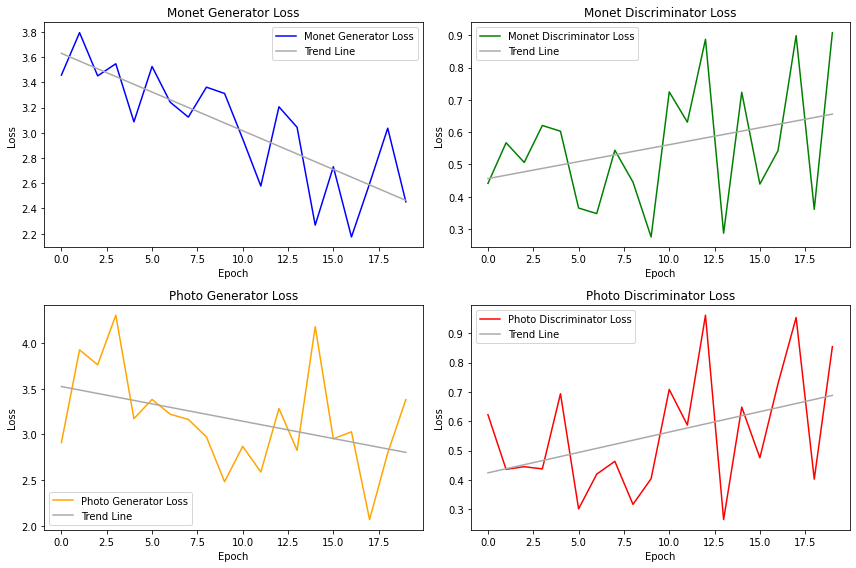

In [19]:
# Call the function and plot the loss throughout epoch
plot_training_hist(compute_epoch_loss(history1))

## Building version 2

In version 2, the generator function has been enhanced with multiple downsampling and upsampling layers. These additions are aimed at improving the model's capacity to extract and reconstruct complex features necessary for generating high-quality Monet-style and photo-style images.

Conversely, the discriminator function in version 2 includes additional layers such as padding, convolutional layers, instance normalization, and leakyReLU activations. These augmentations are intended to enhance the discriminator's ability to discern between real and fake images more effectively, thereby reducing its loss and improving overall model performance.

By integrating these advancements into both the generator and discriminator functions, version 2 of the CycleGAN aims to achieve better image generation capabilities and discriminator accuracy compared to the initial version.

In [10]:
#setting parameter values
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
EPOCHS = 30
BATCH_SIZE = 1

## Generator model

In [11]:
OUTPUT_CHANNELS = 3

def generator_fn():
    inputs = L.Input(shape=[HEIGHT, WIDTH, CHANNELS])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4),                          # (bs, 64, 64, 128)
        downsample(256, 4),                          # (bs, 32, 32, 256)
        downsample(512, 4),                          # (bs, 16, 16, 512)  #version2
        downsample(512, 4),                          # (bs, 8, 8, 512) #version2
        downsample(512, 4),                          # (bs, 4, 4, 512) #version2
        downsample(512, 4),                          # (bs, 2, 2, 512) #version2
        downsample(512, 4),                          # (bs, 1, 1, 512) #version2
        
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024) #version2
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024) #version2
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024) #version2
        upsample(512, 4),                     # (bs, 16, 16, 1024) #version2
        upsample(256, 4),                     # (bs, 32, 32, 512)
        upsample(128, 4),                     # (bs, 64, 64, 256)
        upsample(64, 4),                      # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = L.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                             strides=2,
                             padding='same',
                             kernel_initializer=initializer,
                             activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = L.Concatenate()([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)

## Discriminator model


In [12]:
def discriminator_fn():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    inp = L.Input(shape=[HEIGHT, WIDTH, CHANNELS], name='input_image')
    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
    
    zero_pad1 = L.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = L.Conv2D(512, 4, strides=1,
                    kernel_initializer=initializer,
                    use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    leaky_relu = L.LeakyReLU()(norm1)
    zero_pad2 = L.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    last = L.Conv2D(1, 4, strides=1,
                    kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    # Final convolutional layer without normalization or activation
    last = L.Conv2D(1, 4, strides=1, padding='valid',
                 kernel_initializer=initializer)(down3)  # (bs, 29, 29, 1)
    return Model(inputs=inp, outputs=last)

## Training model

In [13]:
with strategy.scope():
    # Create generators
    monet_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

    # Create discriminators
    monet_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    
    # Create GAN
    gan_model = CycleGan(monet_generator, photo_generator, 
                         monet_discriminator, photo_discriminator)

    gan_model.compile(m_gen_optimizer=monet_generator_optimizer,
                      p_gen_optimizer=photo_generator_optimizer,
                      m_disc_optimizer=monet_discriminator_optimizer,
                      p_disc_optimizer=photo_discriminator_optimizer,
                      gen_loss_fn=generator_loss,
                      disc_loss_fn=discriminator_loss,
                      cycle_loss_fn=calc_cycle_loss,
                      identity_loss_fn=identity_loss)
    

history2 = gan_model.fit(get_gan_dataset(MONET_FILENAMES, PHOTO_FILENAMES, batch_size=BATCH_SIZE), 
                        steps_per_epoch=(n_monet_samples//BATCH_SIZE),
                        epochs=EPOCHS,
                        verbose=2).history

Epoch 1/30
300/300 - 61s - monet_gen_loss: 3.4590 - photo_gen_loss: 3.5689 - monet_disc_loss: 0.6169 - photo_disc_loss: 0.6355
Epoch 2/30
300/300 - 22s - monet_gen_loss: 3.4148 - photo_gen_loss: 3.3197 - monet_disc_loss: 0.8364 - photo_disc_loss: 0.8855
Epoch 3/30
300/300 - 22s - monet_gen_loss: 4.8425 - photo_gen_loss: 4.8148 - monet_disc_loss: 0.4868 - photo_disc_loss: 0.4629
Epoch 4/30
300/300 - 22s - monet_gen_loss: 4.1854 - photo_gen_loss: 3.8093 - monet_disc_loss: 0.6317 - photo_disc_loss: 0.5227
Epoch 5/30
300/300 - 22s - monet_gen_loss: 3.6460 - photo_gen_loss: 4.5601 - monet_disc_loss: 0.6447 - photo_disc_loss: 0.3807
Epoch 6/30
300/300 - 22s - monet_gen_loss: 2.5779 - photo_gen_loss: 2.4650 - monet_disc_loss: 0.6989 - photo_disc_loss: 0.4977
Epoch 7/30
300/300 - 22s - monet_gen_loss: 2.4862 - photo_gen_loss: 3.8317 - monet_disc_loss: 0.6155 - photo_disc_loss: 0.5391
Epoch 8/30
300/300 - 22s - monet_gen_loss: 3.2211 - photo_gen_loss: 3.0528 - monet_disc_loss: 0.6137 - photo_di

In [14]:
import pickle

# Save the history dictionary to a file
with open('history2.pkl', 'wb') as f:
    pickle.dump(history2, f)

In [15]:
import pickle
# Load the history dictionary from the file
with open('history2.pkl', 'rb') as f:
    loaded_history2 = pickle.load(f)

# Review and Analysis

Version 2 of the model shows noticeable improvements, especially in the performance of the discriminator. Both the Monet and photo generator losses continue to trend downwards, similar to version 1. However, the discriminator losses for Monet images are stabilizing rather than increasing as in version 1. Similarly, the discriminator loss for photo images shows slower growth, indicating progress in the model's ability to distinguish between real and generated images.

To further enhance the model, the next step involves increasing the architectural complexity by incorporating residual blocks. Residual blocks introduce skip connections between layers, enhancing the model's capacity for non-linear transformations during training.

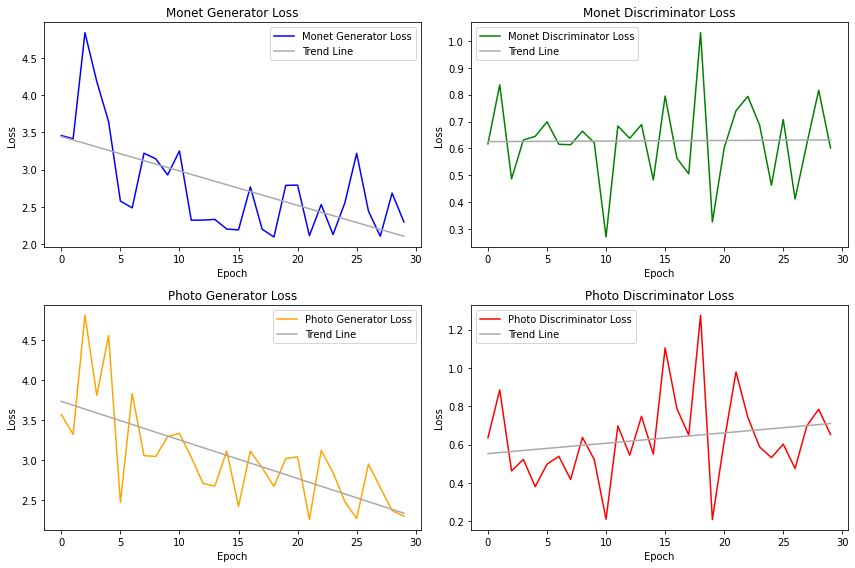

In [20]:
# Call the function and plot the loss throughout epoch
plot_training_hist(compute_epoch_loss(history2))

## Building version 3

In [12]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
EPOCHS = 30
BATCH_SIZE = 1

## Generator & discriminator model

In [13]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add, Concatenate

def residual_block(input_tensor, filters, kernel_size=3, strides=1):
    """Residual block with skip connection"""
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(input_tensor)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def generator_fn():
    inputs = L.Input(shape=[HEIGHT, WIDTH, CHANNELS])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = L.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                             strides=2,
                             padding='same',
                             kernel_initializer=initializer,
                             activation='tanh')

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])
        x = residual_block(x, up.output_shape[-1])  # Apply residual block

    x = last(x)

    return Model(inputs=inputs, outputs=x)

def discriminator_fn():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = L.Input(shape=[HEIGHT, WIDTH, CHANNELS], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    # Version 2 downsampling
    zero_pad1 = L.ZeroPadding2D()(down3)
    conv = L.Conv2D(512, 4, strides=1,
                    kernel_initializer=initializer,
                    use_bias=False)(zero_pad1)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = L.LeakyReLU()(norm1)

    zero_pad2 = L.ZeroPadding2D()(leaky_relu)

    x = residual_block(zero_pad2, 512)  # Apply residual block
    x = L.Conv2D(1, 4, strides=1,
                 kernel_initializer=initializer)(x)

    return Model(inputs=inp, outputs=x)

## Training model

In [14]:
with strategy.scope():
    # Create generators
    monet_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

    # Create discriminators
    monet_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    
    # Create GAN
    gan_model = CycleGan(monet_generator, photo_generator, 
                         monet_discriminator, photo_discriminator)

    gan_model.compile(m_gen_optimizer=monet_generator_optimizer,
                      p_gen_optimizer=photo_generator_optimizer,
                      m_disc_optimizer=monet_discriminator_optimizer,
                      p_disc_optimizer=photo_discriminator_optimizer,
                      gen_loss_fn=generator_loss,
                      disc_loss_fn=discriminator_loss,
                      cycle_loss_fn=calc_cycle_loss,
                      identity_loss_fn=identity_loss)
    

history3 = gan_model.fit(get_gan_dataset(MONET_FILENAMES, PHOTO_FILENAMES, batch_size=BATCH_SIZE), 
                        steps_per_epoch=(n_monet_samples//BATCH_SIZE),
                        epochs=EPOCHS,
                        verbose=2).history

# Call the parse_verbose_output function to capture training details
#results, history, training_time = parse_verbose_output(gan_model,
#                                                      get_gan_dataset(MONET_FILENAMES, PHOTO_FILENAMES, batch_size=BATCH_SIZE),
#                                                      steps_per_epoch=(n_monet_samples // BATCH_SIZE),
#                                                      epochs=EPOCHS)

Epoch 1/30
300/300 - 57s - monet_gen_loss: 3.3968 - photo_gen_loss: 3.6193 - monet_disc_loss: 0.6099 - photo_disc_loss: 0.4893
Epoch 2/30
300/300 - 23s - monet_gen_loss: 3.5441 - photo_gen_loss: 3.2658 - monet_disc_loss: 0.6663 - photo_disc_loss: 0.7140
Epoch 3/30
300/300 - 22s - monet_gen_loss: 3.4914 - photo_gen_loss: 3.0885 - monet_disc_loss: 0.5876 - photo_disc_loss: 0.5424
Epoch 4/30
300/300 - 22s - monet_gen_loss: 3.4684 - photo_gen_loss: 3.3213 - monet_disc_loss: 0.6756 - photo_disc_loss: 0.5475
Epoch 5/30
300/300 - 22s - monet_gen_loss: 2.6783 - photo_gen_loss: 3.4476 - monet_disc_loss: 0.4976 - photo_disc_loss: 0.5610
Epoch 6/30
300/300 - 22s - monet_gen_loss: 2.7620 - photo_gen_loss: 3.1778 - monet_disc_loss: 0.5296 - photo_disc_loss: 0.4734
Epoch 7/30
300/300 - 22s - monet_gen_loss: 2.4676 - photo_gen_loss: 2.9600 - monet_disc_loss: 0.8177 - photo_disc_loss: 0.5850
Epoch 8/30
300/300 - 22s - monet_gen_loss: 2.6845 - photo_gen_loss: 2.8846 - monet_disc_loss: 0.3798 - photo_di

In [15]:
import pickle

# Save the history dictionary to a file
with open('history3.pkl', 'wb') as f:
    pickle.dump(history3, f)

In [16]:
import pickle
# Load the history dictionary from the file
with open('history3.pkl', 'rb') as f:
    loaded_history3 = pickle.load(f)

# Review and Analysis
Version 3 shows a slight improvement over version 2. Now, all four loss metrics are trending downwards, indicating that the models are progressing towards achieving a balanced performance between generators and discriminators. It highlights the collaborative effort required between generators and discriminators to successfully transform images between domains.

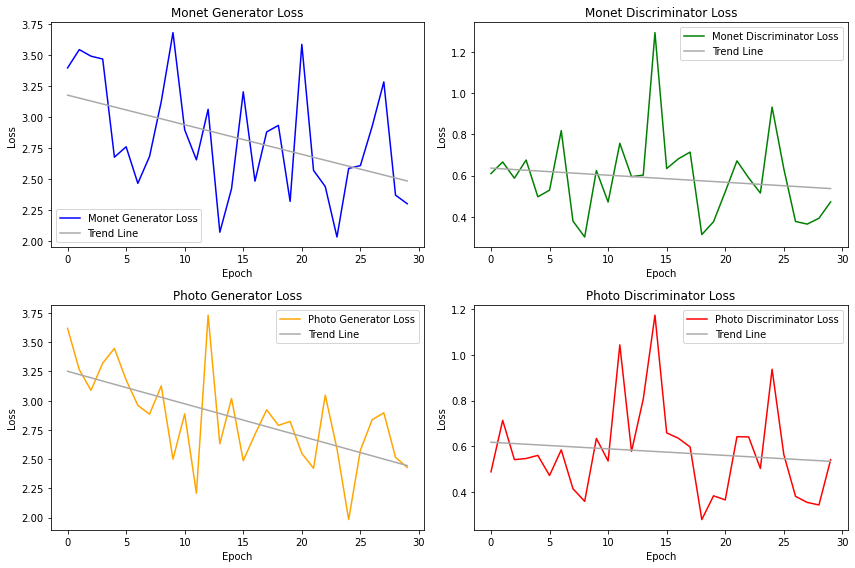

In [17]:
# Call the function and plot the loss throughout epoch
plot_training_hist(compute_epoch_loss(history3))

# Conclusion

Version 3 of the CycleGAN appears to be the best-performing model. Here are the key learnings from this project:

- Increasing the number of downsampling and upsampling layers improves model performance and reduces loss.
- More epochs are necessary to observe trends in the loss measures.
- All four loss measures need to improve simultaneously to develop an overall performing model.
- Residual block layers contribute to building a better model by introducing skip connections and enhancing non-linear transformations.

If time permits, I will continue training for additional epochs.

# Generating Monet images from photo using the trained model

In [18]:
os.makedirs('../images/') # Create folder to save generated images
predict_and_save(load_dataset(PHOTO_FILENAMES).batch(1), monet_generator, '../images/')

# Visualizging the generated images

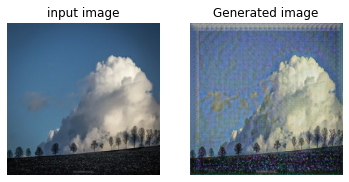

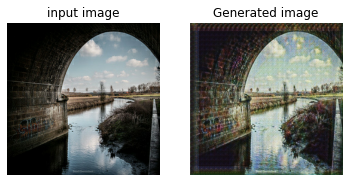

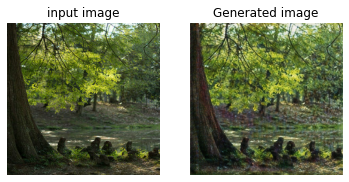

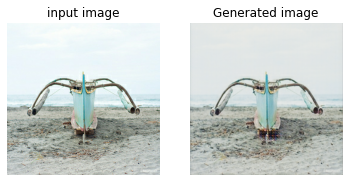

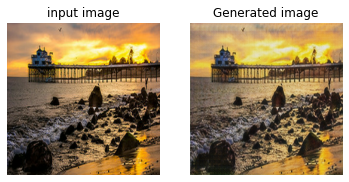

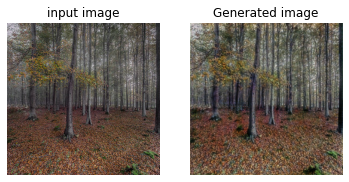

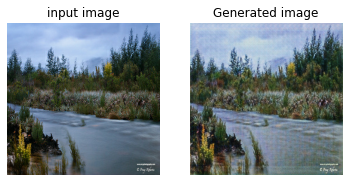

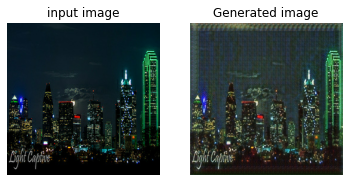

In [19]:
display_generated_samples(load_dataset(PHOTO_FILENAMES).batch(1), monet_generator, 8)

# Archiving image files for submission

In [20]:
shutil.make_archive('/kaggle/working/images/', 'zip', '../images')

print(f"Generated samples: {len([name for name in os.listdir('../images/') if os.path.isfile(os.path.join('../images/', name))])}")

Generated samples: 7038
